# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 2 - Autoencoders 

In [17]:
# torch modules
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# sklearn and skorch modules
from sklearn.metrics import confusion_matrix

# various modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import seaborn as sns
sns.set_theme()

# optuna import
import optuna

# self-made libraries import
from models import StandardAE, DenoisingAE, SupervisedCAE, VariationalAE
from utilities import plot_result, add_noise
from optimization import return_objective

#LIGHTNING
import pytorch_lightning as pl
import torchmetrics

In [16]:
import sys, importlib
importlib.reload(sys.modules['models'])
importlib.reload(sys.modules['optimization'])

<module 'optimization' from 'c:\\Users\\Filippo\\Documents\\POD\\Projects\\NNDL\\HW2\\optimization.py'>

## Dataset

In [3]:
# creating the transformations list
transformations = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(degrees=15, translate=(.05, .05), scale=(0.95,1.05)) , transforms.ToTensor() ])

# loading train and test dataset
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

train_dataset.transform = transformations
test_dataset.transform = transformations


In [4]:
n_cores = 8
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=n_cores)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=n_cores)


## Network definition

In [51]:
trainer = pl.Trainer(max_epochs=10)

model = StandardAE({"opt":"Adam","lr":1e-3,"reg":0,"encoded_space_dim":20,"in_channels":[20,50,40],"linear_size":130,"act_func":nn.ReLU})

trainer.fit(model,train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\Filippo\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name    | Type    | Params
------------------------------------
0 | loss_fn | MSELoss | 0     
1 | encoder | Encoder | 76.8 K
2 | decoder | Decoder | 77.1 K
------------------------------------
153 K     Trainable params
0         Non-trainable params
153 K     Total params
0.616     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 469/469 [01:00<00:00,  7.73it/s, loss=0.0164, v_num=99]


In [52]:
torch.save(model.state_dict(), "autoencoder_weights.pth")
torch.save(model.encoder.state_dict(), "encoder_weights.pth")

# Training parameters

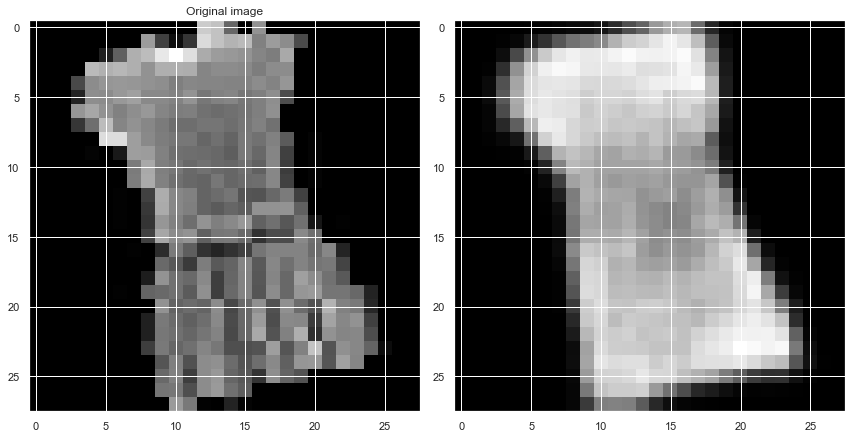

In [53]:
im=train_dataset[3][0][0]
rec_im=model.forward(im.reshape([1,1,28,28])).detach()
plot_result(im,rec_im)

# Optuna optimization

In [6]:
# objective = return_objective(StandardAE,train_dataset,10,device="cpu")
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=70)
study = joblib.load("study.pkl")
#joblib.dump(study,"study.pkl")


# Denoising

In [ ]:
trainer = pl.Trainer(max_epochs=10)

model_den = DenoisingAE({"opt":"Adam","lr":1e-2,"reg":0,"encoded_space_dim":15,"in_channels":[8,16,32],"linear_size":64,"act_func":nn.ReLU})

trainer.fit(model_den,train_dataloader)

In [ ]:
im=add_noise(train_dataset[1][0][0])
rec_im=model.forward(im.reshape([1,1,28,28])).detach()
plot_result(im,rec_im)

In [56]:
# objective_den = return_objective(DenoisingAE,train_dataset,10)

# study_den = optuna.create_study(direction='minimize')
# study_den.optimize(objective_den, n_trials=70)
study = joblib.load("study_den.pkl")
# joblib.dump(study_den,"study_den.pkl")


FileNotFoundError: [Errno 2] No such file or directory: 'study_den.pkl'

# Supervised learning application

In [55]:
trainer = pl.Trainer(max_epochs=10)

model = SupervisedCAE({"opt":"Adam","lr":1e-4,"reg":0,"encoded_space_dim":20,"in_channels":[20,50,40],"linear_size":130,"act_func":nn.ReLU, "out_linear_size":200},PATH="encoder_weights.pth")

trainer.fit(model,train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name       | Type             | Params
------------------------------------------------
0 | encoder    | Encoder          | 76.8 K
1 | fine_tuner | Sequential       | 6.2 K 
2 | accuracy   | Accuracy         | 0     
3 | loss_fn    | CrossEntropyLoss | 0     
------------------------------------------------
6.2 K     Trainable params
76.8 K    Non-trainable params
83.0 K    Total params
0.332     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 469/469 [00:29<00:00, 15.70it/s, loss=0.562, v_num=101]


In [57]:
torch.save(model.state_dict(), "supervisedCAE_weights.pth")

In [39]:
# model.load_state_dict(torch.load("supervisedCAE_weights.pth"))

<All keys matched successfully>

In [58]:
trainer.test(model,test_dataloader)

Testing: 0it [00:00, ?it/s]tensor([[-1.1916e+01, -1.5572e+01, -1.4785e+01,  ..., -9.0491e-01,
         -7.0087e+00, -1.4255e+00],
        [-6.0483e+00, -6.8647e+00, -3.4419e-01,  ..., -1.4816e+01,
         -6.8037e+00, -9.4541e+00],
        [-9.8925e+00, -2.2075e-04, -1.4822e+01,  ..., -2.3691e+01,
         -1.2494e+01, -1.9291e+01],
        ...,
        [-1.3280e-01, -9.2353e+00, -7.3621e+00,  ..., -2.3874e+01,
         -9.3081e+00, -1.8999e+01],
        [-4.5544e+00, -9.5587e+00, -2.7316e+00,  ..., -8.6222e+00,
         -8.9399e-02, -6.0252e+00],
        [-6.3772e+00, -7.6072e+00, -1.1496e+00,  ..., -1.4269e+01,
         -6.3764e+00, -1.0432e+01]]) tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 3, 9, 8, 7, 0,
        2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8,
        0, 1, 4, 2, 3

[{'accuracy': 0.7792999744415283}]

In [59]:
test_input_data = test_dataset.data.type(torch.float32).reshape([10000,1,28,28])
test_label_data = test_dataset.targets.type(torch.int64).reshape(10000)

In [60]:
y_pred = torch.argmax(torch.exp(model.forward(test_input_data)),dim=1)

Epoch 1:   0%|          | 0/469 [04:20<?, ?it/s, loss=0.605, v_num=100]


<AxesSubplot:>

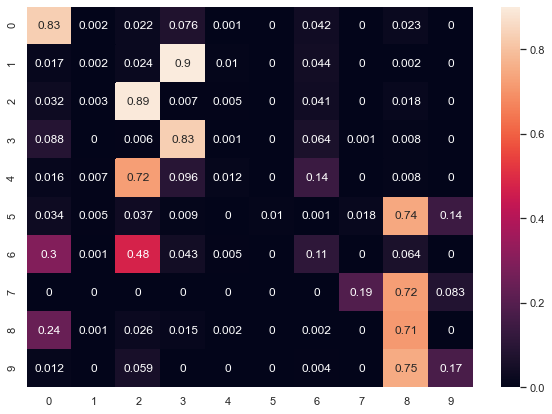

In [61]:
# plotting the confusion matrix for the prediction
fig = plt.figure(figsize = (10,7))
c_matrix = confusion_matrix(test_label_data.detach().numpy(),y_pred)
sns.heatmap(c_matrix/c_matrix.astype(float).sum(axis=1) ,annot=True)


# Network analysis

In [ ]:
# # losses plot
# f, ax = plt.subplots(figsize=(7, 7))
# sns.lineplot(x=np.arange(len(train_loss)),y=train_loss, label='Train loss', markers=True,  ax=ax)
# sns.lineplot(x=np.arange(len(test_loss))*250,y=test_loss, label='Validation loss',markers=True, ax=ax)

# ax.set_yscale("log")

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# ### Get the encoded representation of the test samples
# encoded_samples = []
# for sample in tqdm(test_dataset):
#     img = sample[0].unsqueeze(0).to(device)
#     label = sample[1]
#     # Encode image
#     encoder.eval()
#     with torch.no_grad():
#         encoded_img  = encoder(img)
#     # Append to list
#     encoded_img = encoded_img.flatten().cpu().numpy()
#     encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
#     encoded_sample['label'] = label
#     encoded_samples.append(encoded_sample)

In [ ]:
# # Convert to a dataframe
# encoded_samples = pd.DataFrame(encoded_samples)
# encoded_samples

In [ ]:
# if encoded_space_dim == 10:
#     # Generate a custom sample
#     custom_encoded_sample = [-6, -30.0,2,20,30,50,60,70,10,1]
#     encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

#     # Decode sample
#     decoder.eval()
#     with torch.no_grad():
#         generated_img  = decoder(encoded_value)

#     plt.figure(figsize=(12,10))
#     plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
#     plt.show()

In [ ]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2)
# encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
# plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
# encoded_samples_reduced_PCA

In [ ]:
# plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())

# Variational Autoencoder

In [ ]:
trainer = pl.Trainer(max_epochs=2)

model = VariationalAE(hyper={"opt":"Adam","lr":1e-2,"reg":0,"encoded_space_dim":35,"in_channels":[8,16,32],"linear_size":64,"act_func":nn.ReLU, "out_linear_size":128})

trainer.fit(model,train_dataloader)

In [ ]:
im=train_dataset[3][0][0]
rec_im=model.forward(train_dataset[3][0].reshape([1,1,28,28]))[0][0].detach()
plot_result(im,rec_im)

In [ ]:
objective_vae = return_objective(VariationalAE,train_dataset,10)

study_vae = optuna.create_study(direction='minimize')
study_vae.optimize(objective_vae, n_trials=70)
#study = joblib.load("study.pkl")
joblib.dump(study_vae,"study_vae.pkl")